In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [ ]:
onion_area_path = "/Users/rashidkarimov/Desktop/agro/data/processed/analysis/statistics_committee/onion_area_features.csv"
potato_area_path = "/Users/rashidkarimov/Desktop/agro/data/processed/analysis/statistics_committee/potato_area_features.csv"

onion_df = pd.read_csv(onion_area_path)
potato_df = pd.read_csv(potato_area_path)

if 'onion_area' in onion_df.columns:
    onion_df.rename(columns={'onion_area': 'SownArea'}, inplace=True)
if 'potato_area' in potato_df.columns:
    potato_df.rename(columns={'potato_area': 'SownArea'}, inplace=True)

onion_df['Crop'] = 'Onion'
potato_df['Crop'] = 'Potato'

df = pd.concat([onion_df, potato_df], ignore_index=True)
df = df[df['Setting'] != "Republic of Azerbaijan"]  

df.dropna(subset=['Setting','year','SownArea','first5_sum','last5_sum','growth','std_dev','cagr'], inplace=True)
df.head()


,Setting,year,SownArea,first5_sum,last5_sum,growth,std_dev,cagr,Crop
1,Baku city,2000,10.0,67.0,19.9,-47.1,6.760594,-0.038023,Onion
2,Nakhchivan Autonomous Republic,2000,288.0,2034.0,1931.9,-102.1,67.778564,-0.009730,Onion
4,Babak district,2000,70.0,656.0,160.0,-496.0,50.841613,-0.143225,Onion
5,Julfa district,2000,41.0,232.0,198.0,-34.0,22.488604,-0.087424,Onion
7,Ordubad district,2000,36.0,280.0,272.0,-8.0,16.431622,-0.144274,Onion


In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 3300 entries, 1 to 4175
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Setting     3300 non-null   object 
 1   year        3300 non-null   int64  
 2   SownArea    3300 non-null   float64
 3   first5_sum  3300 non-null   float64
 4   last5_sum   3300 non-null   float64
 5   growth      3300 non-null   float64
 6   std_dev     3300 non-null   float64
 7   cagr        3300 non-null   float64
 8   Crop        3300 non-null   object 
dtypes: float64(6), int64(1), object(2)
memory usage: 257.8+ KB


,year,SownArea,first5_sum,last5_sum,growth,std_dev,cagr
count,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000,3300.000000
mean,2011.522727,1077.035242,5319.802121,4792.955061,-526.847061,235.795090,-0.010616
std,6.930288,3014.501443,17180.549256,12755.162976,6185.759764,501.198999,0.052129
min,2000.000000,0.100000,9.000000,14.800000,-57892.900000,3.633529,-0.144274
25%,2006.000000,85.000000,615.000000,251.800000,-746.200000,38.583126,-0.040787
50%,2012.000000,305.500000,1402.000000,989.500000,-70.000000,116.144374,-0.003819
75%,2018.000000,845.000000,3717.000000,3781.800000,400.000000,205.971927,0.023621
max,2023.000000,39578.000000,179201.000000,121308.100000,15230.200000,4691.344386,0.162644


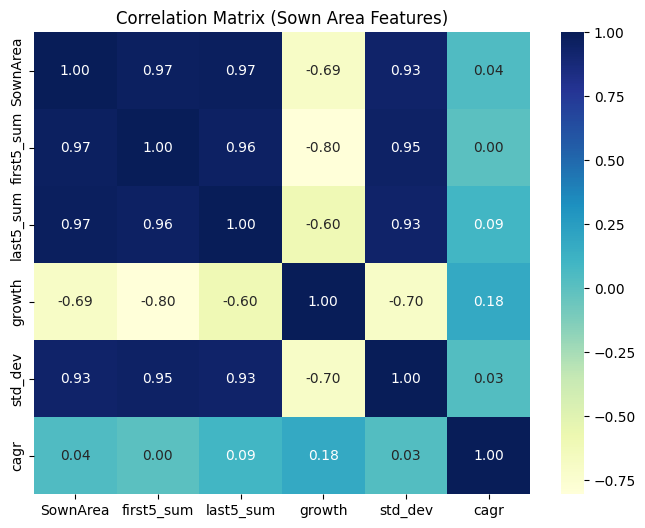

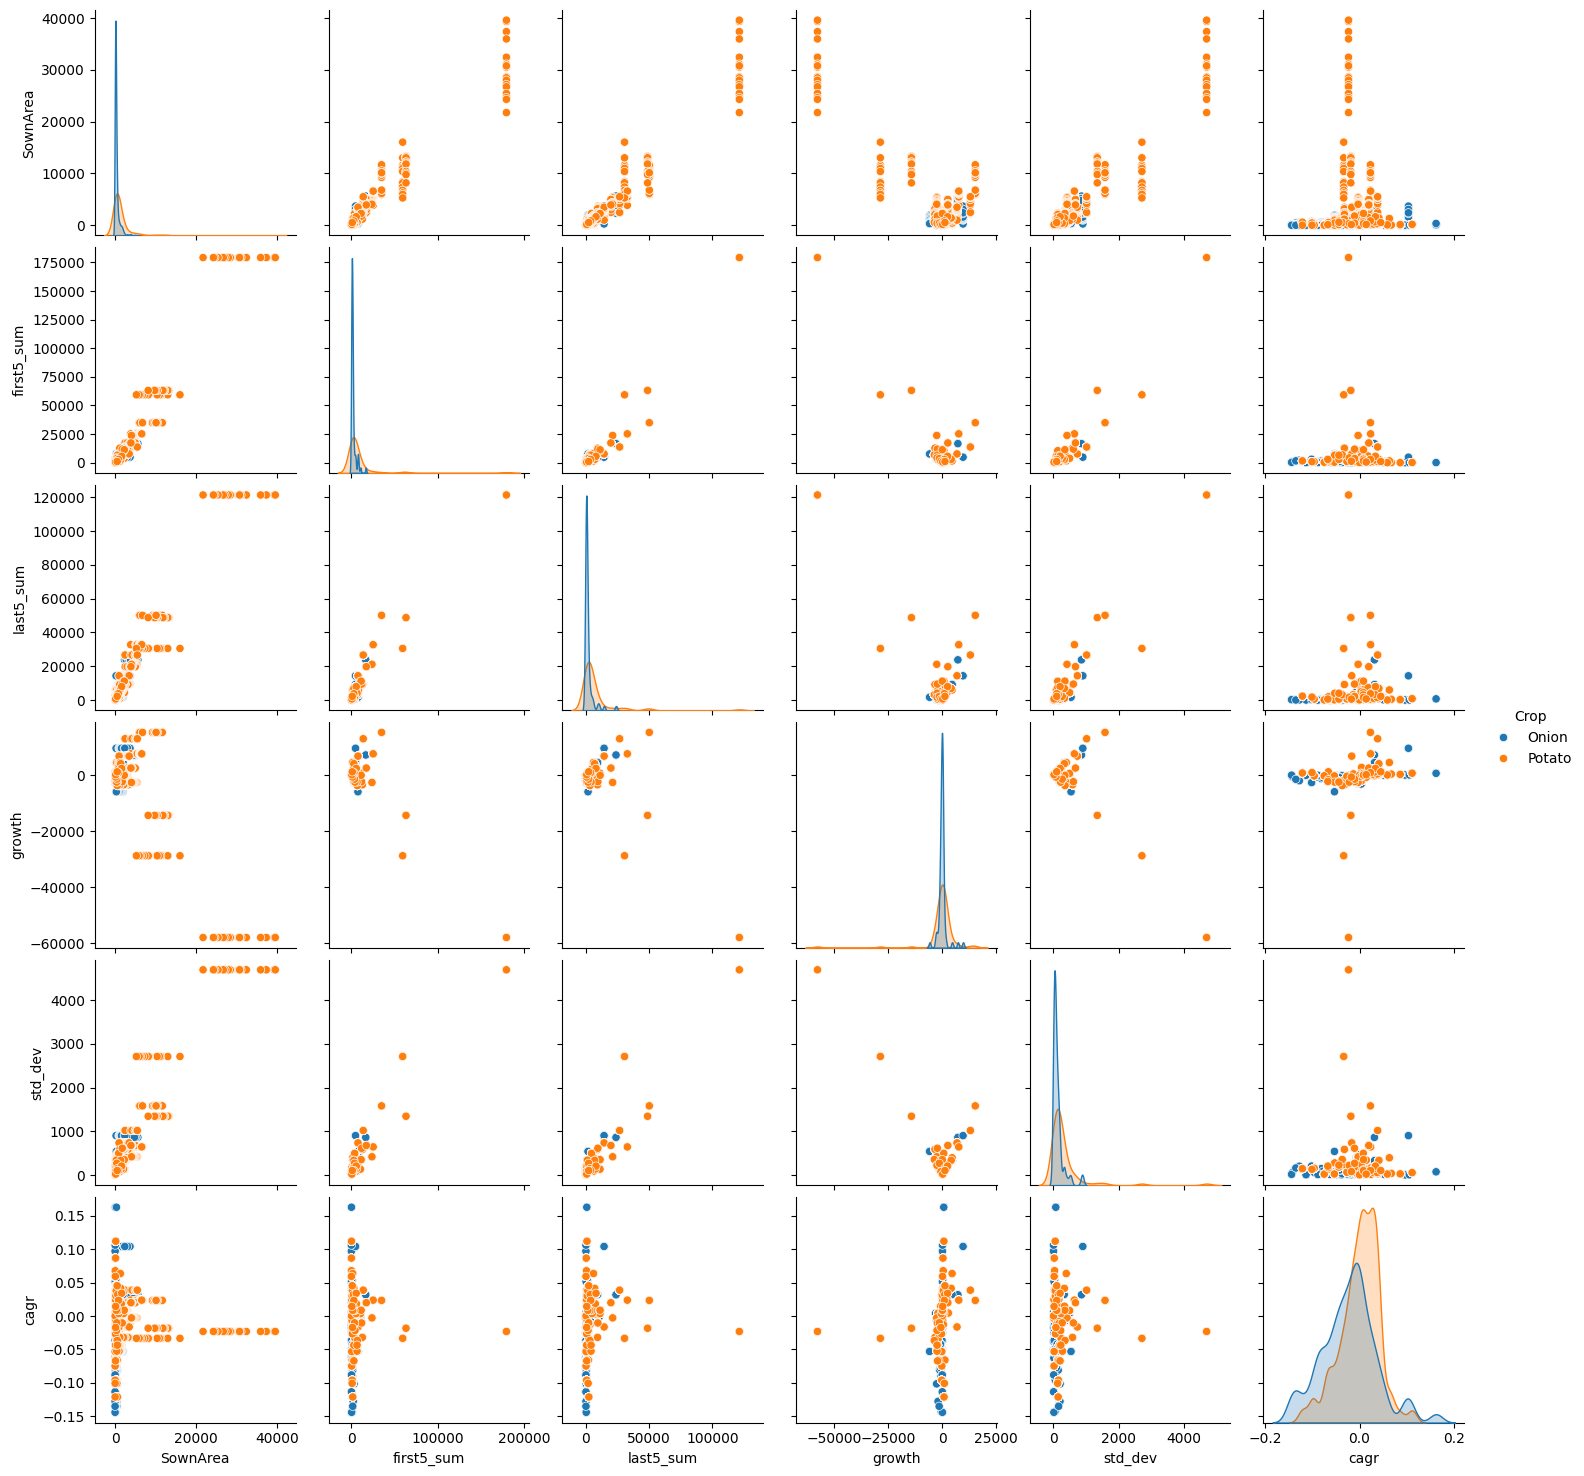

In [4]:
num_cols = ['SownArea','first5_sum','last5_sum','growth','std_dev','cagr']
corr = df[num_cols].corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title("Correlation Matrix (Sown Area Features)")
plt.show()

sns.pairplot(df[num_cols + ['Crop']], hue='Crop')
plt.show()


/var/folders/rd/v7chfg_s48s67l7bpbm9w9180000gn/T/ipykernel_2969/1976507991.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


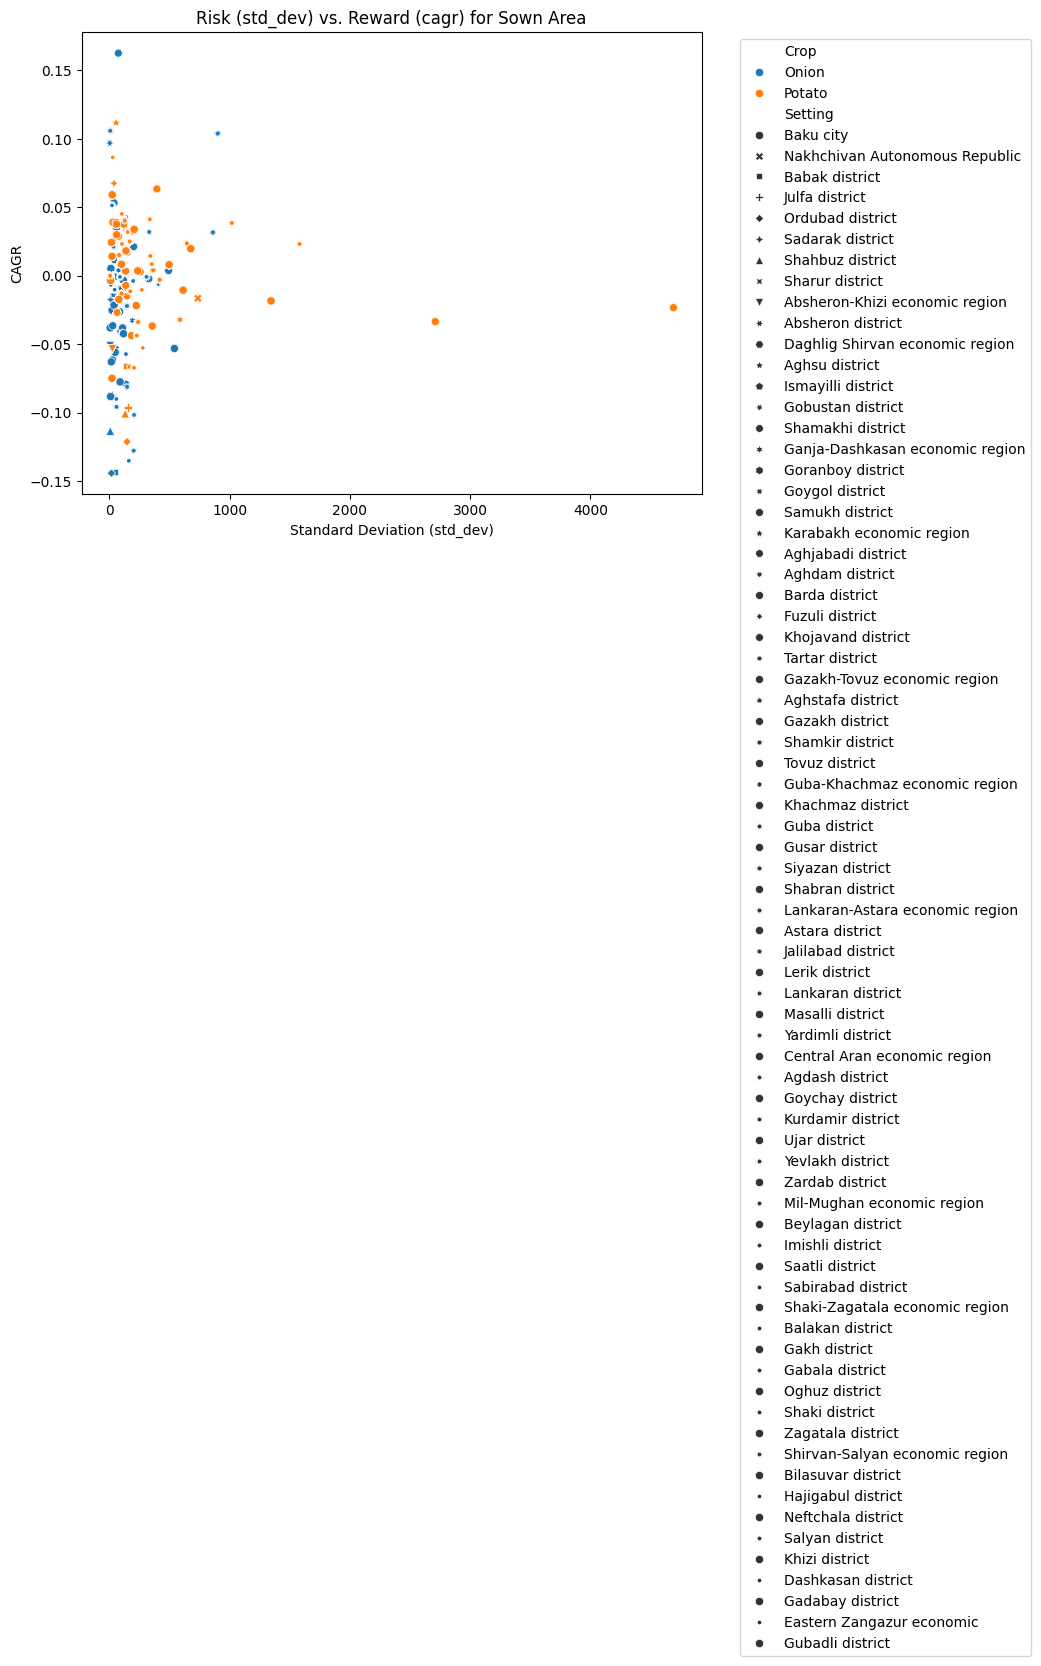

In [5]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df, 
    x='std_dev', 
    y='cagr', 
    hue='Crop',
    style='Setting'
)
plt.title("Risk (std_dev) vs. Reward (cagr) for Sown Area")
plt.xlabel("Standard Deviation (std_dev)")
plt.ylabel("CAGR")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


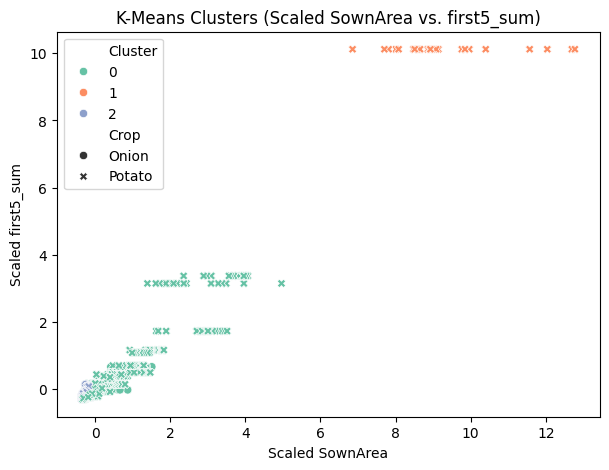

,SownArea,first5_sum,last5_sum,growth,std_dev,cagr
Cluster,,,,,,
0,1428.150996,6371.118406,6847.521923,476.403517,294.760559,0.026230
1,29347.087500,179201.000000,121308.100000,-57892.900000,4691.344386,-0.023275
2,263.350701,1519.359873,779.289745,-740.070127,103.611476,-0.050461


In [6]:
features = ['SownArea','first5_sum','last5_sum','growth','std_dev','cagr']
X = df[features].copy()
X.fillna(0, inplace=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(7,5))
sns.scatterplot(
    x=X_scaled[:,0], 
    y=X_scaled[:,1], 
    hue=df['Cluster'], 
    style=df['Crop'], 
    palette='Set2'
)
plt.title("K-Means Clusters (Scaled SownArea vs. first5_sum)")
plt.xlabel("Scaled SownArea")
plt.ylabel("Scaled first5_sum")
plt.show()

df.groupby('Cluster')[features].mean()


In [7]:
target_col = 'growth'
model_features = ['SownArea','first5_sum','std_dev','cagr']

X_train, X_test, y_train, y_test = train_test_split(
    df[model_features], 
    df[target_col], 
    test_size=0.2, 
    random_state=42
)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

coef_df = pd.DataFrame({'Feature': model_features, 'Coefficient': lr.coef_})
print("Intercept:", lr.intercept_)
print(coef_df)

mae = np.mean(np.abs(y_pred - y_test))
r2 = lr.score(X_test, y_test)
print(f"MAE: {mae:.2f}, R^2: {r2:.2f}")


Intercept: 339.24461864913746
      Feature   Coefficient
0    SownArea      3.002490
1  first5_sum     -0.890453
2     std_dev      3.341224
3        cagr  13683.789769
MAE: 1390.86, R^2: 0.72


Top 5 Regions by Average Growth per Crop (Sown Area):
                             Setting    Crop   growth
82   Lankaran-Astara economic region  Potato  15230.2
68                Jalilabad district  Potato  12967.0
6                    Aghdam district   Onion   9569.0
118                 Shamkir district  Potato   7587.0
71          Karabakh economic region   Onion   7178.8
90    Nakhchivan Autonomous Republic  Potato   6769.3
117                 Shamkir district   Onion   4494.0
44                   Gazakh district  Potato   4488.0
8                 Aghjabadi district   Onion   1547.7
24                 Beylagan district   Onion   1095.0


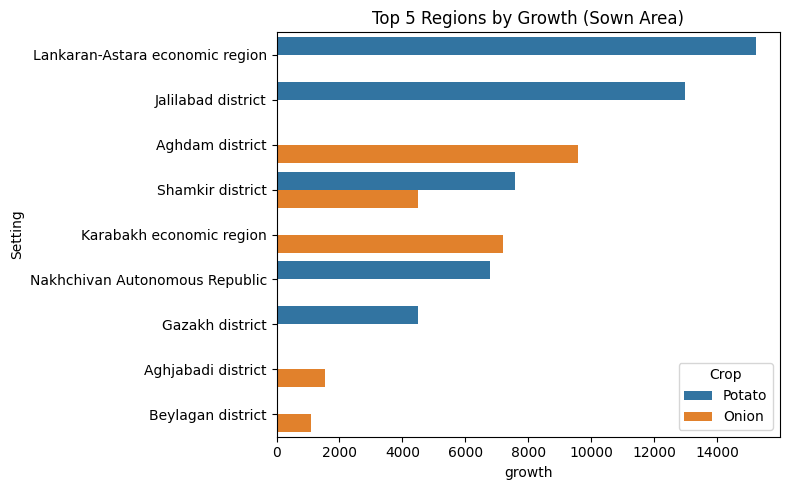

In [8]:
top5 = (
    df.groupby(['Setting','Crop'])['growth']
      .mean()
      .reset_index()
      .sort_values('growth', ascending=False)
      .groupby('Crop')
      .head(5)
)

print("Top 5 Regions by Average Growth per Crop (Sown Area):")
print(top5)

plt.figure(figsize=(8,5))
sns.barplot(data=top5, x='growth', y='Setting', hue='Crop')
plt.title("Top 5 Regions by Growth (Sown Area)")
plt.tight_layout()
plt.show()
